In [35]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import numpy as np
import tensorflow as tf
import seaborn as sn
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
class_names = ['neutralne', 'oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc']

## Get train and test datasets and process them to be TF Dataset objects

In [2]:
with open('../data/train.pickle', 'rb') as handle:
    train_X, train_y = pickle.load(handle)
    
with open('../data/test.pickle', 'rb') as handle:
    test_X, test_y = pickle.load(handle)

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)

## Define 2 layer model with dropout

Train with RMSprop as an optimizer because it works better with momentum.

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(768,)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(9, activation="softmax", name="predictions")
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])
model.fit(train_dataset, epochs=120)

Epoch 1/120
53/53 [==============================] - 0s 4ms/step - loss: 1.3960 - categorical_accuracy: 0.5828
Epoch 2/120
53/53 [==============================] - 0s 5ms/step - loss: 1.1845 - categorical_accuracy: 0.6422
Epoch 3/120
53/53 [==============================] - 0s 5ms/step - loss: 1.1156 - categorical_accuracy: 0.6642
Epoch 4/120
53/53 [==============================] - 0s 5ms/step - loss: 1.0786 - categorical_accuracy: 0.6781
Epoch 5/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0529 - categorical_accuracy: 0.6847
Epoch 6/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0290 - categorical_accuracy: 0.6888
Epoch 7/120
53/53 [==============================] - 0s 4ms/step - loss: 1.0018 - categorical_accuracy: 0.6986
Epoch 8/120
53/53 [==============================] - 0s 4ms/step - loss: 0.9986 - categorical_accuracy: 0.7004
Epoch 9/120
53/53 [==============================] - 0s 4ms/step - loss: 0.9768 - categorical_accuracy: 0.7069
E

53/53 [==============================] - 0s 4ms/step - loss: 0.4832 - categorical_accuracy: 0.8305
Epoch 75/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4687 - categorical_accuracy: 0.8432
Epoch 76/120
53/53 [==============================] - 0s 4ms/step - loss: 0.4776 - categorical_accuracy: 0.8299
Epoch 77/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4455 - categorical_accuracy: 0.8441
Epoch 78/120
53/53 [==============================] - 0s 4ms/step - loss: 0.4596 - categorical_accuracy: 0.8370
Epoch 79/120
53/53 [==============================] - 0s 4ms/step - loss: 0.4431 - categorical_accuracy: 0.8459
Epoch 80/120
53/53 [==============================] - 0s 4ms/step - loss: 0.4385 - categorical_accuracy: 0.8510
Epoch 81/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4519 - categorical_accuracy: 0.8391
Epoch 82/120
53/53 [==============================] - 0s 5ms/step - loss: 0.4388 - categorical_accuracy: 0.8438
Epoch

## Get model schema

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               196864    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 9)                 1161      
Total params: 230,921
Trainable params: 230,921
Non-trainable params: 0
_________________________________________________________________


## Make predictions on test dataset and calculate classification metrics

In [14]:
predictions = np.argmax(model.predict(test_dataset), axis=-1)
true_y = np.argmax(test_y, axis=-1)

In [15]:
print(classification_report(true_y, predictions, target_names=class_names))

              precision    recall  f1-score   support

   neutralne       0.79      0.95      0.86       518
 oczekiwanie       0.21      0.11      0.14        28
      podziw       0.62      0.35      0.44        52
      radosc       0.57      0.33      0.42        83
      smutek       0.33      0.10      0.15        20
      strach       0.50      0.08      0.13        13
      wstret       0.08      0.08      0.08        24
 zaskoczenie       0.50      0.17      0.25        12
       zlosc       0.58      0.57      0.58        93

    accuracy                           0.71       843
   macro avg       0.47      0.30      0.34       843
weighted avg       0.67      0.71      0.68       843



## Check missed predictions

In [16]:
miss_class = (predictions != true_y).nonzero()[0]

In [17]:
miss_class[:15]

array([ 0,  1,  3,  4,  6, 13, 17, 22, 27, 34, 38, 47, 59, 60, 61])

In [10]:
## get original texts instead of embedded vectors
with open('../data/test_org.pickle', 'rb') as handle:
    test_X_org = pickle.load(handle)

In [11]:
for idx in miss_class[:15]:
    print(f"Predicted: {class_names[predictions[idx]]}, Acc label: {class_names[true_y[idx]]}")
    print(test_X_org[idx])
    print()

Predicted: radosc, Acc label: podziw
Dziękuję urzędnikom miejskim, w szczególności @BartekCiazynski, za dobrą i szybką decyzję! Zamieszki narodowców trwają nadal — 1,5 godziny po rozwiązaniu marszu. Dobrze, że debacie o bezpieczeństwo wrocławian i wrocławianek.#WROCŁAW WOLNY OD FASZYMU!

Predicted: neutralne, Acc label: radosc
Awww #Wrocław #KotekWrocek #WrocławTwierdząDemokracji https://t.co/S51T16o3zR

Predicted: neutralne, Acc label: podziw
Doskonale prowadzone wirtualne (mimo zalewu trolli na czacie) konsultacje parkingowe podczas #pandemia #koronawirus + ciekawe pomysły urzędników na płatną strefę na Żoliborzu. Będzie relacja @GazetaStoleczna

Predicted: zlosc, Acc label: neutralne
Uchodźcy w Calais zarabiają na muralu Banksy'ego https://t.co/szITbrbcGN #UchodzcyWeFrancji #Calais #Uchodzcy

Predicted: neutralne, Acc label: radosc
Czasem wszystkim czego potrzebujesz, jest nasze mojito 💚#wroclaw #wroclove #rzeznicza28 #coctailbarmax #mojito https://t.co/cPTZNYPKJ9

Predicted: wstret

<AxesSubplot:>

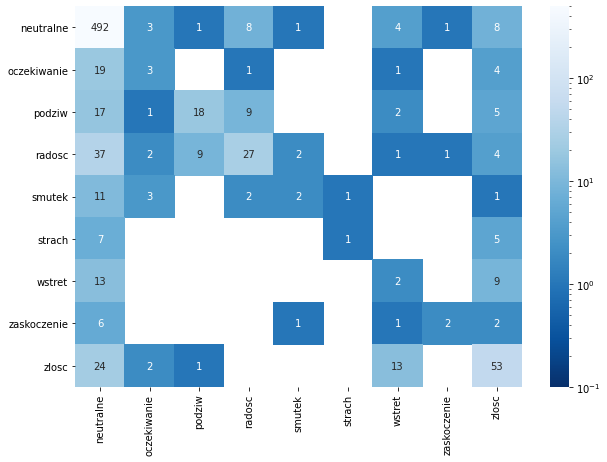

In [49]:
cm = confusion_matrix(true_y, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, norm=LogNorm(vmin=0.1, vmax=500), fmt="d")

In [23]:
cm

array([[492,   3,   1,   8,   1,   0,   4,   1,   8],
       [ 19,   3,   0,   1,   0,   0,   1,   0,   4],
       [ 17,   1,  18,   9,   0,   0,   2,   0,   5],
       [ 37,   2,   9,  27,   2,   0,   1,   1,   4],
       [ 11,   3,   0,   2,   2,   1,   0,   0,   1],
       [  7,   0,   0,   0,   0,   1,   0,   0,   5],
       [ 13,   0,   0,   0,   0,   0,   2,   0,   9],
       [  6,   0,   0,   0,   1,   0,   1,   2,   2],
       [ 24,   2,   1,   0,   0,   0,  13,   0,  53]])